190805 조진욱



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir -p ~/.kaggle # ~/ 의 경우 루트에서 출발하겠다는 이야기
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/ # 그냥 / 의 경우 현재있는 cd 폴더에서 시작하겠다는 이야기인듯
!chmod 600 ~/.kaggle/kaggle.json


In [0]:
!pip install kaggle

In [0]:
!kaggle competitions download -c nyc-taxi-trip-duration

  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 41.3MB/s]
 44% 9.00M/20.3M [00:00<00:00, 33.7MB/s]
100% 20.3M/20.3M [00:00<00:00, 58.5MB/s]
 91% 57.0M/62.9M [00:01<00:00, 34.8MB/s]
100% 62.9M/62.9M [00:01<00:00, 39.5MB/s]


In [0]:
!unzip /content/test.zip
!unzip /content/train.zip

Archive:  /content/test.zip
  inflating: test.csv                
Archive:  /content/train.zip
  inflating: train.csv               




# 필사 시작

K means - clustering 을 통해 New York 를 지역에 따라 클러스터해서 시간의 흐름에 따라 교통이 어떻게 변화하는지 볼 것임. residential 영역이 저녁에 교통이 복잡할것이고, commercial 영역은 낮에 몰릴 것임. rich nightlife 밤에 교통이 복잡하겠지?  duration prediction 을 할 때 보통 사람들의 도착지가 영역에 따라, 시간에 따라 어떻게  달라지는 지 알 수 있어서 좋을 것임 


Import
---



In [0]:
import os
import pandas as pd
import numpy as np

from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from dateutil import parser

import io
import base64

from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
print(check_output(["ls", "../content"]).decode("utf8"))



drive
sample_data
sample_submission.zip
test.csv
test.zip
train.csv
train.zip




Read Data
---



In [0]:
df_org = pd.read_csv("/content/train.csv")

In [0]:
df_org.head()

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

In [0]:
df_org.describe()

vendor_id  passenger_count  ...  dropoff_latitude  trip_duration
count  1.458644e+06     1.458644e+06  ...      1.458644e+06   1.458644e+06
mean   1.534950e+00     1.664530e+00  ...      4.075180e+01   9.594923e+02
std    4.987772e-01     1.314242e+00  ...      3.589056e-02   5.237432e+03
min    1.000000e+00     0.000000e+00  ...      3.218114e+01   1.000000e+00
25%    1.000000e+00     1.000000e+00  ...      4.073588e+01   3.970000e+02
50%    2.000000e+00     1.000000e+00  ...      4.075452e+01   6.620000e+02
75%    2.000000e+00     2.000000e+00  ...      4.076981e+01   1.075000e+03
max    2.000000e+00     9.000000e+00  ...      4.392103e+01   3.526282e+06

[8 rows x 7 columns]

Remove rides to and from far aways areas

In [0]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df_org.copy()

df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

Plot rides

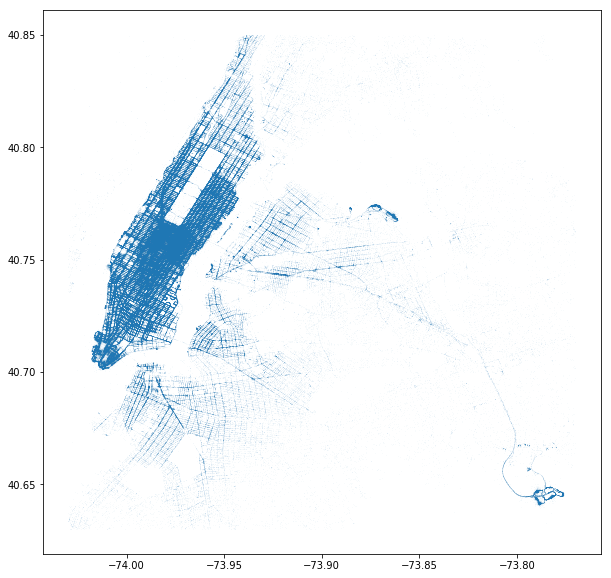

In [0]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)

plt.figure(figsize = (10, 10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 0.05)
plt.show()



In [0]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude


Cluster
---

pickup / dropoff 지점으로 클러스터링


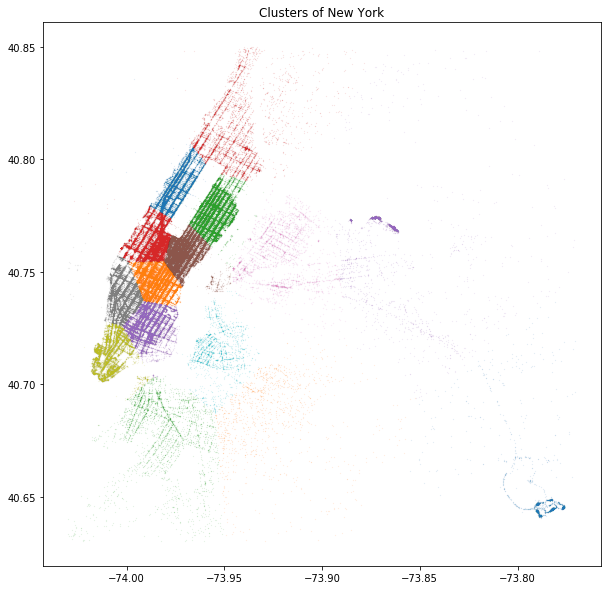

In [0]:
kmeans = KMeans(n_clusters=15, random_state=15, n_init= 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10, 10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()


clustering result 를 보면 꽤나 NY가 다른 이웃들로 나눠진 것과 비슷하게 보인다. 센트럴 파크의 upper east, upper west 를 그레이와 핑크로 각각 나눈 것을 볼 수 있다. west midtown 은 blue 로, 첼시 나 서쪽 west village 지역은 브라운 색으로, 등등.



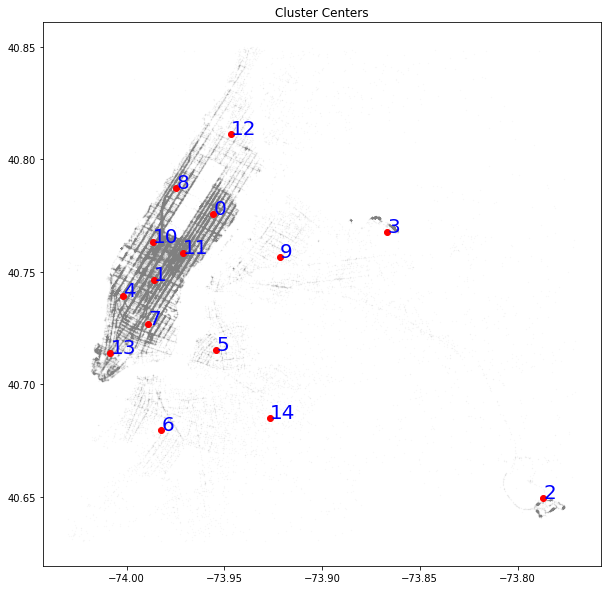

In [0]:
fig, ax = plt.subplots(figsize = (10, 10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label],
            '.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1], 'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1]), color = 'b', fontsize = 20)
    ax.set_title('Cluster Centers')
plt.show()



In [0]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour)

In [0]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:, 0]
clusters['y'] = kmeans.cluster_centers_[:, 1]
clusters['label'] = range(len(clusters))

In [0]:
loc_df = loc_df.sample(5000)


Taxi rides from one cluster to another
---
he following animation, every arrow represents rides from one cluster to another. The width of the arrow is proportional to the relative amount of trips in the relevant hour.


MovieWriter imagemagick unavailable. Trying to use pillow instead.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



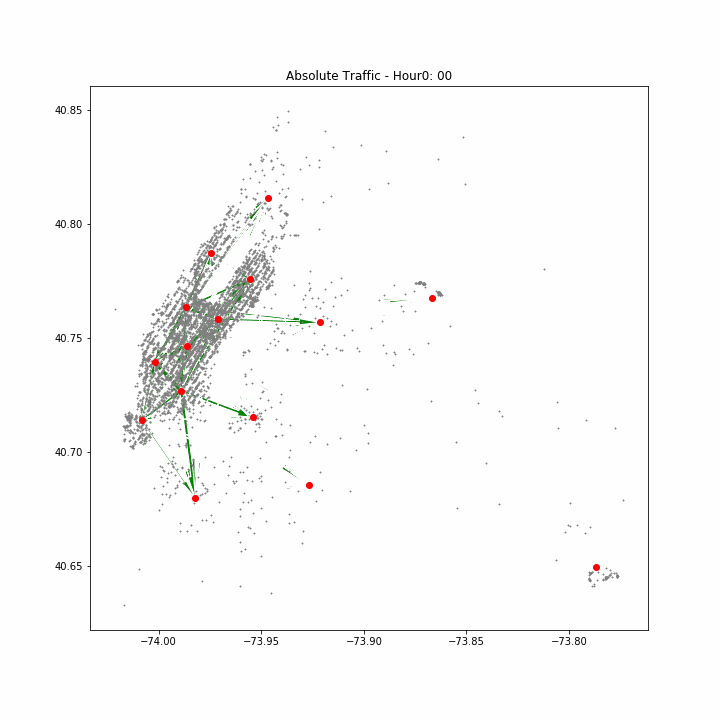

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour' + str(int(hour)) + ': 00')
    plt.figure(figsize = (10, 10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label],
               '.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');
    
    
    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides, len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y,
                        edgecolor = 'white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
    
    
ani = animation.FuncAnimation(fig, animate, sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer = 'imagemagick', fps = 2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()

encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))
                                                                                                                     
    

MovieWriter imagemagick unavailable. Trying to use pillow instead.
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



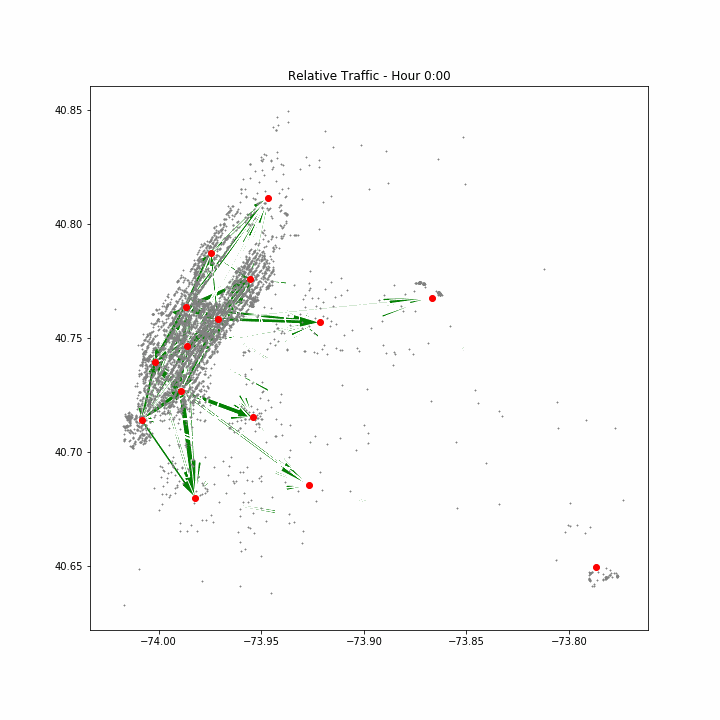

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))


Neighborhood Analysis
---



In [0]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [0]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1, 1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1, 1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))


Now, lets plot a heatmap and look where do passengers go to and from (이것은 모든 라이드의 agg value 이다)

In [0]:
import plotly.offline as py
import plotly.graph_objs as go

trace = go.Heatmap(z = np.array(rides_df.as_matrix()),
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)

layout = dict(title = '<b>Neighbors Interaction<b>',
             titlefont = dict(size = 30,
                             color = ('rgb(100, 100, 100)')),
             margin = dict(t=100,r=100,b=100,l=150),
             yaxis = dict(
             title = ' <b> From </b>'),
             xaxis = dict(
             title = '<b> To </b>'))

data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'labelled-heatmap')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [0]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis = 1)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

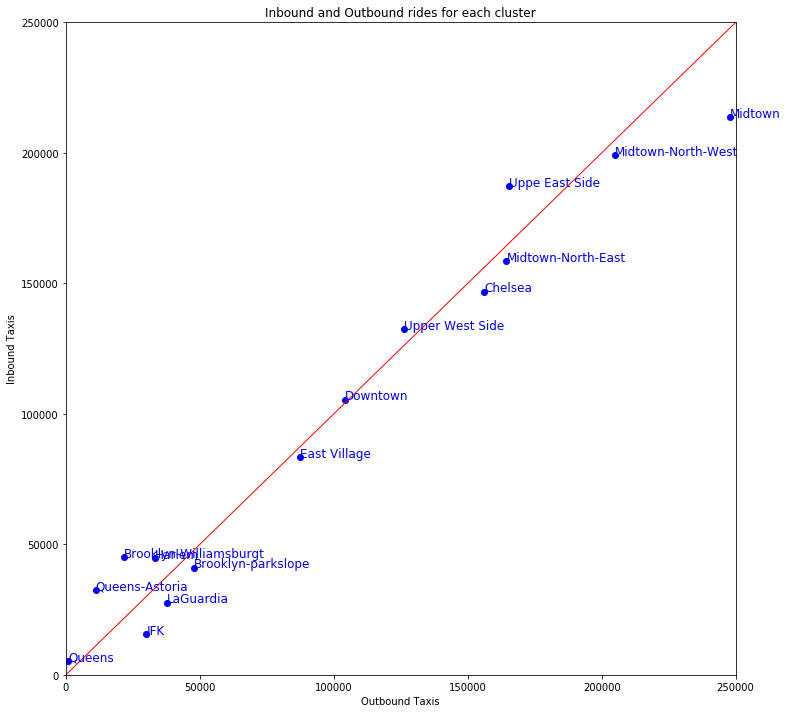

In [0]:
fig, ax = plt.subplots(figsize = (12, 12))
for i in range(len(rides_df)):
    ax.plot(rides_df.sum(axis=1)[i], rides_df.sum(axis = 0)[i], 'o',color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)
    
ax.plot([0, 250000], [0, 250000], color='r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0, 250000])
ax.set_ylim([0, 250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')



Winter vs. Summer
---



In [0]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x: parser.parse(x).month)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



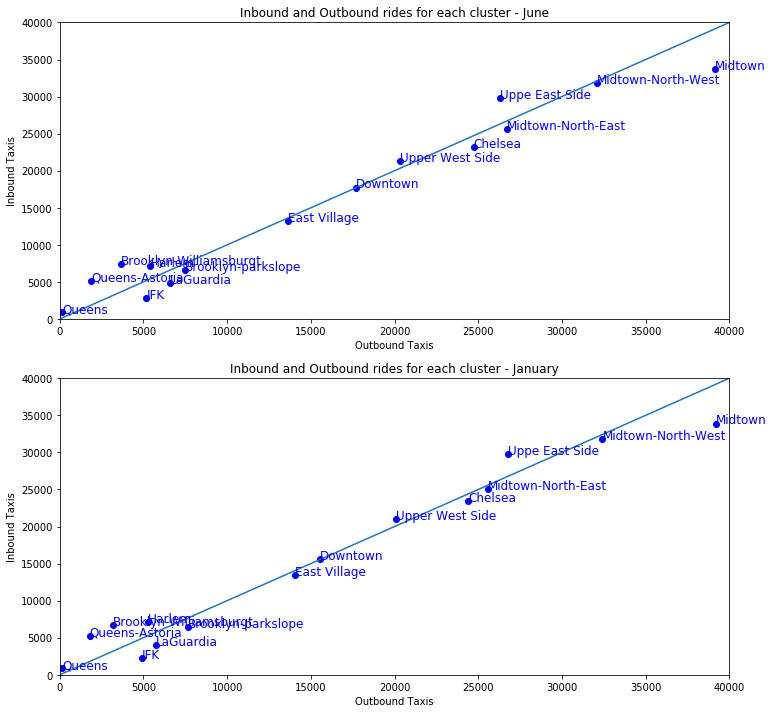

In [0]:
fig,ax = plt.subplots(2,figsize = (12,12))

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 6)]))
for i in range(len(rides_df)):  
    ax[0].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0,40000])
ax[0].set_ylim([0,40000])
ax[0].plot([0,40000],[0,40000])


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)]))
rides_df = rides_df.drop('name', axis = 1)
for i in range(len(rides_df)):  
    ax[1].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0,40000])
ax[1].set_ylim([0,40000])
ax[1].plot([0,40000],[0,40000])